In [76]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

import os

from tqdm import tqdm
from sklearn.decomposition import PCA
import cv2
from sklearn.ensemble import RandomForestClassifier

In [77]:
def load_images_from_folder_fer_2013(folder):
    images = []
    labels = []
    for label_folder in os.listdir(folder):
        label_folder_path = os.path.join(folder, label_folder)
        if os.path.isdir(label_folder_path):
            for image_file in os.listdir(label_folder_path):
                image_path = os.path.join(label_folder_path, image_file)
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (48, 48))
                images.append(img.flatten())
                labels.append(label_folder)
    return np.array(images), np.array(labels)

In [78]:
train_folder = '../../../../Data/fer2013/train'
test_folder = '../../../../Data/fer2013/validation'
X_train, y_train = load_images_from_folder_fer_2013(train_folder)
X_test, y_test = load_images_from_folder_fer_2013(test_folder)

In [79]:
images_directory = '../../../../Data/images/train'

In [80]:
def prepare_data_and_apply_pca(directory, n_components=10):
    all_images = []
    labels = []
    for emotion_folder in os.listdir(directory):
        emotion_folder_path = os.path.join(directory, emotion_folder)
        if os.path.isdir(emotion_folder_path):
            for image_file in os.listdir(emotion_folder_path):
                image_path = os.path.join(emotion_folder_path, image_file)
                img = cv2.imread(image_path)
                img_gray = cv2.cvtColor(cv2.resize(img, (48, 48)), cv2.COLOR_BGR2GRAY).flatten()
                all_images.append(img_gray)
                labels.append(emotion_folder)
    
    all_images = np.array(all_images)
    
    # PCA modelini eğitin ve veri setini dönüştürün
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(all_images)
    
    return features_pca, labels


In [81]:
import numpy as np

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


In [82]:
def predict_with_euclidean_distance(X_train, y_train, X_test):
    predictions = []
    for test_sample in X_test:
        # Test örneği ile tüm eğitim örnekleri arasındaki mesafeleri hesapla
        distances = [euclidean_distance(test_sample, train_sample) for train_sample in X_train]
        # En küçük mesafeye sahip eğitim örneğinin indeksini bul
        min_index = np.argmin(distances)
        # Bu eğitim örneğinin etiketini tahmin olarak kullan
        predictions.append(y_train[min_index])
    return predictions


PCA METHOD UYGULAMA

In [83]:
def find_best_pca(X_train, y_train, X_test, y_test):
    component_accuracy = []

    for n_components in tqdm(range(1, 100)):
        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # Modeli tanımla ve eğit
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train_pca, y_train)

        # Eğitim seti üzerinde tahmin yap ve doğruluk oranını hesapla
        y_pred_train = model.predict(X_train_pca)
        train_accuracy = accuracy_score(y_train, y_pred_train)
        #print(f"Component: {n_components} --  Eğitim Doğruluğu: {train_accuracy}")

        # Test seti üzerinde tahmin yap ve doğruluk oranını hesapla
        y_pred_test = model.predict(X_test_pca)
        test_accuracy = accuracy_score(y_test, y_pred_test)
        #print(f"Component: {n_components} -- Test Doğruluğu: {test_accuracy}")

        component_accuracy.append({'component':  n_components, 'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy})

        if len(component_accuracy) > 5:
            # Early stopping, if 3 times decreases
            if all(current['test_accuracy'] <= prev['test_accuracy'] for current, prev in zip(component_accuracy[-3:], component_accuracy[-4:-1])):
                print("Erken durdurma: Son 3 test doğruluğunda azalma trendi.")
                break
            threshold = 0.01
            # Early stopping, if acc dif less than threshold:0.01 times decreases
            recent_accuracies = [acc['test_accuracy'] for acc in component_accuracy[-5:]]
            if max(recent_accuracies) - min(recent_accuracies) < threshold:
                print("Erken durdurma: Son 5 test doğruluğundaki fark 0.01'den az.")
                break
        
    return component_accuracy

def best_accuracy_component(component_accuracy):
    best_accuracy = max(component_accuracy, key=lambda x:x['test_accuracy'])
    return best_accuracy

In [84]:
def plot_accuracy_by_components(results):
    # Component değerlerini ve karşılık gelen accuracy değerlerini çıkar
    components = [result['component'] for result in results]
    train_accuracies = [result['train_accuracy'] for result in results]
    test_accuracies = [result['test_accuracy'] for result in results]

    # Çizgi grafikleri çiz
    plt.figure(figsize=(10, 6))
    plt.plot(components, train_accuracies, label='Eğitim Doğruluğu', marker='o')
    plt.plot(components, test_accuracies, label='Test Doğruluğu', marker='x')


    plt.xticks(np.arange(components[0], components[-1]+1, 3))
    plt.title('PCA Bileşen Sayısına Göre Eğitim ve Test Doğruluğu')
    plt.xlabel('PCA Bileşen Sayısı')
    plt.ylabel('Doğruluk Oranı')
    plt.legend()

    # Göster
    plt.grid(True)
    plt.show()

In [85]:
train_folder = '../../../../Data/fer2013/train'
test_folder = '../../../../Data/fer2013/validation'
X_train, y_train = load_images_from_folder_fer_2013(train_folder)
X_test, y_test = load_images_from_folder_fer_2013(test_folder)

In [86]:
component_accuracy = find_best_pca(X_train, y_train, X_test, y_test)

  0%|          | 0/99 [00:00<?, ?it/s]

Eğitim seti özellikleri: (28821, 1)
Test seti özellikleri: (7066, 1)


  1%|          | 1/99 [00:07<11:51,  7.26s/it]

Component: 1 --  Eğitim Doğruluğu: 0.9980916692689359
Component: 1 -- Test Doğruluğu: 0.2346447778092273
Eğitim seti özellikleri: (28821, 2)
Test seti özellikleri: (7066, 2)


  2%|▏         | 2/99 [00:16<13:38,  8.44s/it]

Component: 2 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 2 -- Test Doğruluğu: 0.2649306538352675
Eğitim seti özellikleri: (28821, 3)
Test seti özellikleri: (7066, 3)


  3%|▎         | 3/99 [00:25<14:04,  8.80s/it]

Component: 3 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 3 -- Test Doğruluğu: 0.2959241437871497
Eğitim seti özellikleri: (28821, 4)
Test seti özellikleri: (7066, 4)


  4%|▍         | 4/99 [00:37<15:33,  9.83s/it]

Component: 4 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 4 -- Test Doğruluğu: 0.3223889046136428
Eğitim seti özellikleri: (28821, 5)
Test seti özellikleri: (7066, 5)


  5%|▌         | 5/99 [00:48<16:24, 10.47s/it]

Component: 5 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 5 -- Test Doğruluğu: 0.3457401641664308
Eğitim seti özellikleri: (28821, 6)
Test seti özellikleri: (7066, 6)


  6%|▌         | 6/99 [01:00<16:54, 10.91s/it]

Component: 6 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 6 -- Test Doğruluğu: 0.3600339654684404
Eğitim seti özellikleri: (28821, 7)
Test seti özellikleri: (7066, 7)


  7%|▋         | 7/99 [01:12<17:12, 11.22s/it]

Component: 7 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 7 -- Test Doğruluğu: 0.3731955844891027
Eğitim seti özellikleri: (28821, 8)
Test seti özellikleri: (7066, 8)


  8%|▊         | 8/99 [01:24<17:29, 11.53s/it]

Component: 8 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 8 -- Test Doğruluğu: 0.37928106425134445
Eğitim seti özellikleri: (28821, 9)
Test seti özellikleri: (7066, 9)


  9%|▉         | 9/99 [01:38<18:36, 12.41s/it]

Component: 9 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 9 -- Test Doğruluğu: 0.3971129351825644
Eğitim seti özellikleri: (28821, 10)
Test seti özellikleri: (7066, 10)


 10%|█         | 10/99 [01:53<19:14, 12.98s/it]

Component: 10 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 10 -- Test Doğruluğu: 0.40348146051514294
Eğitim seti özellikleri: (28821, 11)
Test seti özellikleri: (7066, 11)


 11%|█         | 11/99 [02:07<19:40, 13.41s/it]

Component: 11 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 11 -- Test Doğruluğu: 0.40716105292952165
Eğitim seti özellikleri: (28821, 12)
Test seti özellikleri: (7066, 12)


 12%|█▏        | 12/99 [02:21<19:46, 13.63s/it]

Component: 12 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 12 -- Test Doğruluğu: 0.4078686668553637
Eğitim seti özellikleri: (28821, 13)
Test seti özellikleri: (7066, 13)


 13%|█▎        | 13/99 [02:36<19:52, 13.87s/it]

Component: 13 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 13 -- Test Doğruluğu: 0.4162185111803
Eğitim seti özellikleri: (28821, 14)
Test seti özellikleri: (7066, 14)


 14%|█▍        | 14/99 [02:51<20:23, 14.39s/it]

Component: 14 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 14 -- Test Doğruluğu: 0.42584206057175206
Eğitim seti özellikleri: (28821, 15)
Test seti özellikleri: (7066, 15)


 15%|█▌        | 15/99 [03:07<20:42, 14.79s/it]

Component: 15 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 15 -- Test Doğruluğu: 0.4319275403339938
Eğitim seti özellikleri: (28821, 16)
Test seti özellikleri: (7066, 16)


 16%|█▌        | 16/99 [03:24<21:14, 15.35s/it]

Component: 16 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 16 -- Test Doğruluğu: 0.4319275403339938
Eğitim seti özellikleri: (28821, 17)
Test seti özellikleri: (7066, 17)


 17%|█▋        | 17/99 [03:41<21:51, 16.00s/it]

Component: 17 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 17 -- Test Doğruluğu: 0.4416926125106142
Eğitim seti özellikleri: (28821, 18)
Test seti özellikleri: (7066, 18)


 18%|█▊        | 18/99 [03:59<22:20, 16.54s/it]

Component: 18 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 18 -- Test Doğruluğu: 0.4439569770733088
Eğitim seti özellikleri: (28821, 19)
Test seti özellikleri: (7066, 19)


 19%|█▉        | 19/99 [04:17<22:42, 17.03s/it]

Component: 19 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 19 -- Test Doğruluğu: 0.43730540617039343
Eğitim seti özellikleri: (28821, 20)
Test seti özellikleri: (7066, 20)


 20%|██        | 20/99 [04:35<22:41, 17.23s/it]

Component: 20 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 20 -- Test Doğruluğu: 0.437163883385225
Eğitim seti özellikleri: (28821, 21)
Test seti özellikleri: (7066, 21)


 20%|██        | 20/99 [04:52<19:14, 14.61s/it]

Component: 21 --  Eğitim Doğruluğu: 0.9982651538808508
Component: 21 -- Test Doğruluğu: 0.4358901783187093
Erken durdurma: Son 3 test doğruluğunda azalma trendi.


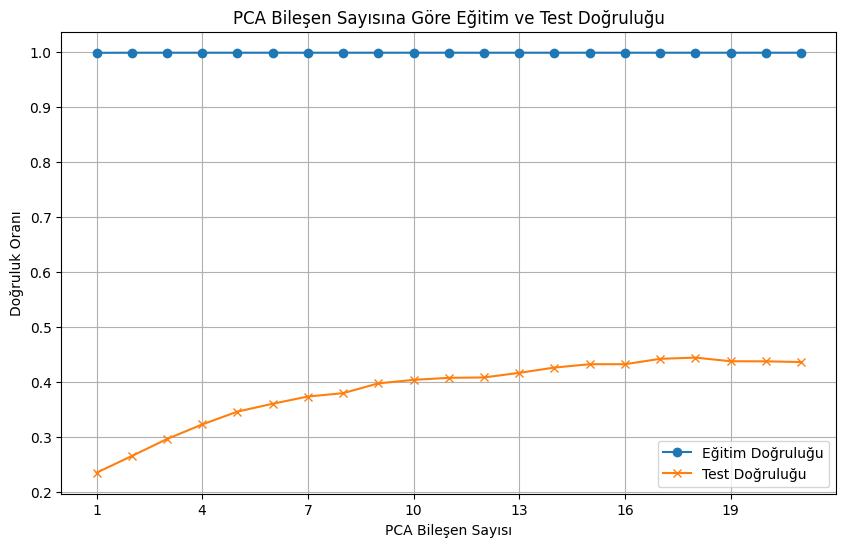

Best accuracy component: {'component': 18, 'train_accuracy': 0.9982651538808508, 'test_accuracy': 0.4439569770733088}


In [89]:
plot_accuracy_by_components(component_accuracy)
print(f"Best accuracy component: {best_accuracy_component(component_accuracy)}")

In [90]:
import joblib

def export_pca(pca, filename):
    joblib.dump(pca, filename)
    print(f"PCA modeli '{filename}' olarak kaydedildi.")
def export_classifier(classifier, filename):
    joblib.dump(classifier, filename)
    print(f"Model '{filename}' olarak kaydedildi.")

In [92]:
component_count = best_accuracy_component(component_accuracy)['component']
pca = PCA(n_components=component_count)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Sınıflandırıcıyı eğit
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

export_pca(pca, f'pca_model{component_count}.pkl')
export_classifier(model, f'classifier_model{component_count}.pkl')


PCA modeli 'pca_model18.pkl' olarak kaydedildi.
Model 'classifier_model18.pkl' olarak kaydedildi.
